# Campus recruitment analysis

Link to the dataset: https://www.kaggle.com/benroshan/factors-affecting-campus-placement <br>
Sorry for my English please /\

## Data

__Feature list__ (`Variable`: Definition):

- `sl_no`: Serial Number
- `gender`: Gender - Male='M',Female='F'
- `ssc_p`: Secondary Education percentage - 10th Grade
- `ssc_b`: Board of Education - Central/Others
- `hsc_p`: Higher Secondary Education percentage - 12th Grade
- `hsc_b`: Board of Education - Central/Others
- `hsc_s`: Specialization in Higher Secondary Education
- `degree_p`: Degree Percentage
- `degree_t`: Under Graduation (Degree type) - Field of degree education
- `workex`: Work Experience
- `etest_p`: Employability test percentage (conducted by college)
- `specialisation`: Post Graduation (MBA) - Specialization
- `mba_p`: MBA percentage
- `status`: Status of placement - Placed/Not placed
- `salary`: Salary offered by corporate to candidates

__Questions:__<br>
1. Which factor influenced a candidate in getting placed?
2. Does percentage matters for one to get placed?
3. Which degree specialization is much demanded by corporate?
4. Play with the data conducting all statistical tests.

__Placement_Data_Full_Class.csv__ - the dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

import itertools

import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

import statsmodels.formula.api as smf

## First look

The dataset:

In [2]:
data = pd.read_csv('Placement_Data_Full_Class.csv')
data.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


There are some na-values in `salary` column but salary is specified only for placed people so it's useless for answering __questions__.

In [4]:
np.all((data.status == 'Not Placed') == data.salary.isna())

True

As well as `sl_no` column, it doesn't provide any useful information:

In [5]:
np.all(data.sl_no == np.arange(1, 216))

True

Dropping these columns and moving on:

In [6]:
data.drop(['sl_no', 'salary'], axis=1, inplace=True)

## Visualizations

Let's divide our features by type (binary, categorical and numerical) and plot their distributions and distributions of `status` for all of them:

In [7]:
bin_features = ['gender', 'ssc_b', 'hsc_b', 'workex', 'specialisation']
cat_features = ['hsc_s', 'degree_t']
num_features = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']

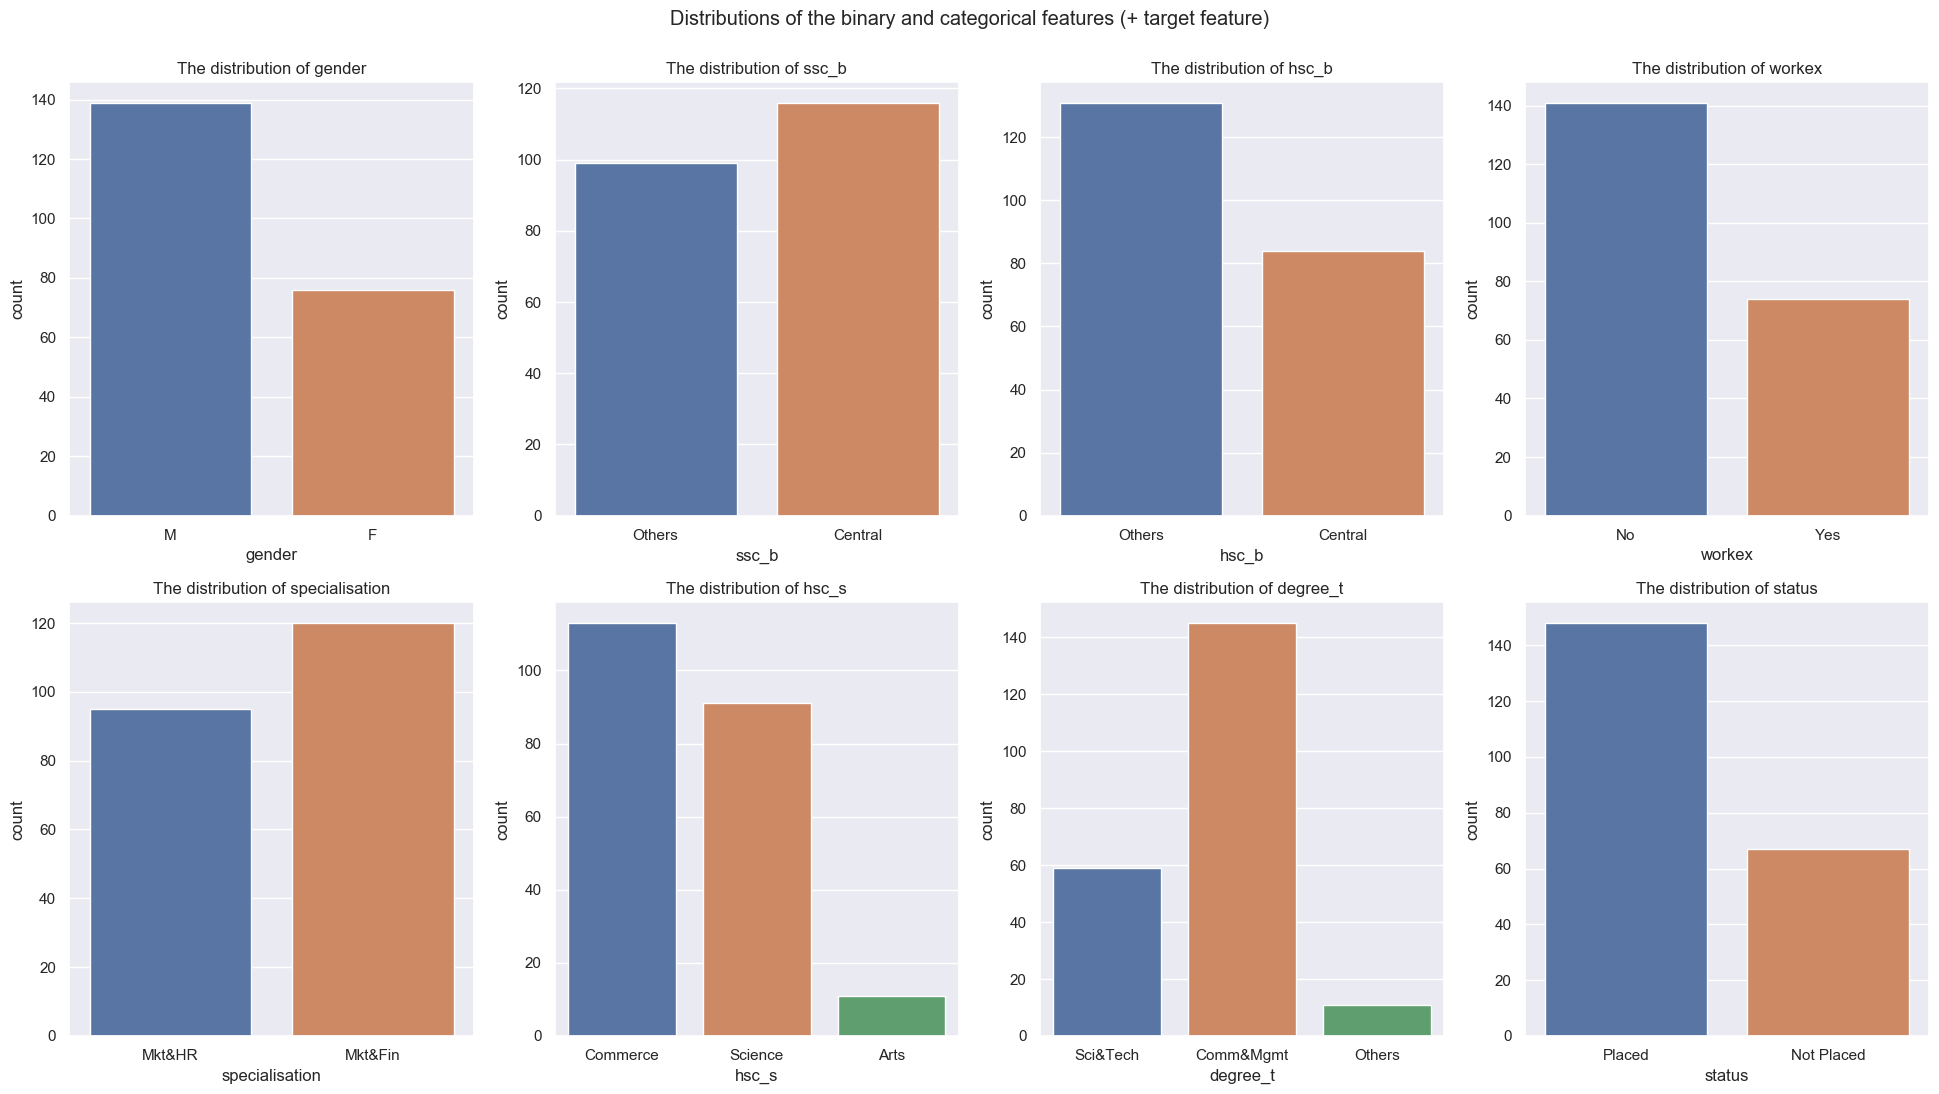

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

feature_names = iter(bin_features + cat_features + ['status'])
for row in range(2):
    for col in range(4):
        feature_name = next(feature_names)
        sns.countplot(data[feature_name], ax=axes[row, col])
        axes[row, col].set_title(f'The distribution of {feature_name}')

fig.suptitle('Distributions of the binary and categorical features (+ target feature)')
fig.subplots_adjust(top=0.92)
fig.show()

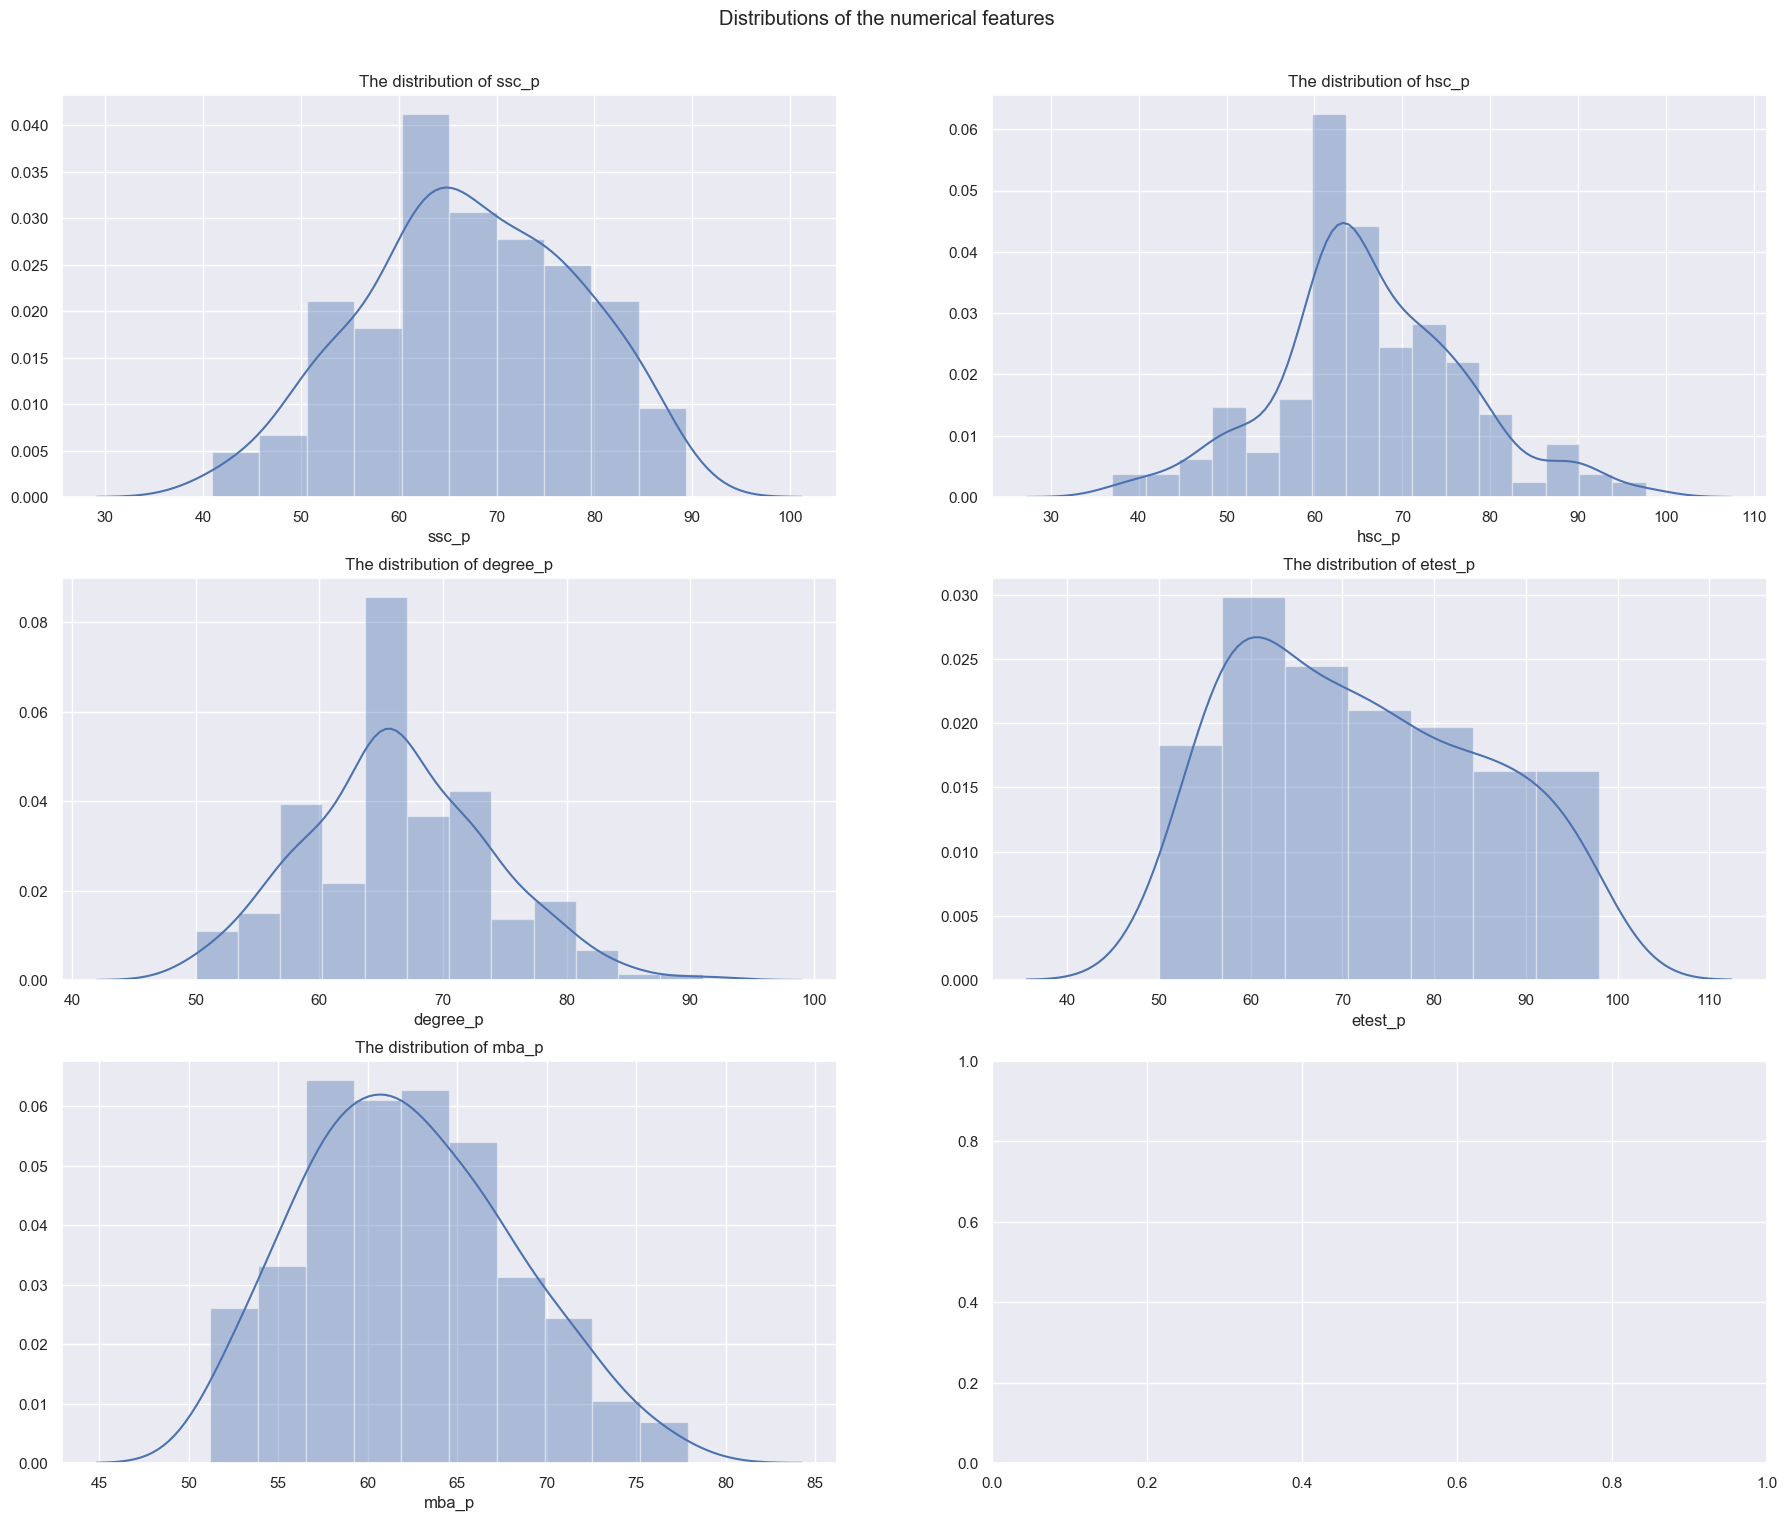

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(22, 17))

feature_names = iter(num_features)
for row in range(3):
    for col in range(2):
        try:
            feature_name = next(feature_names)
        except StopIteration:
            break
        
        sns.distplot(data[feature_name], ax=axes[row, col])    
        axes[row, col].set_title(f'The distribution of {feature_name}')
        

fig.suptitle('Distributions of the numerical features')
fig.subplots_adjust(top=0.93)
fig.show()

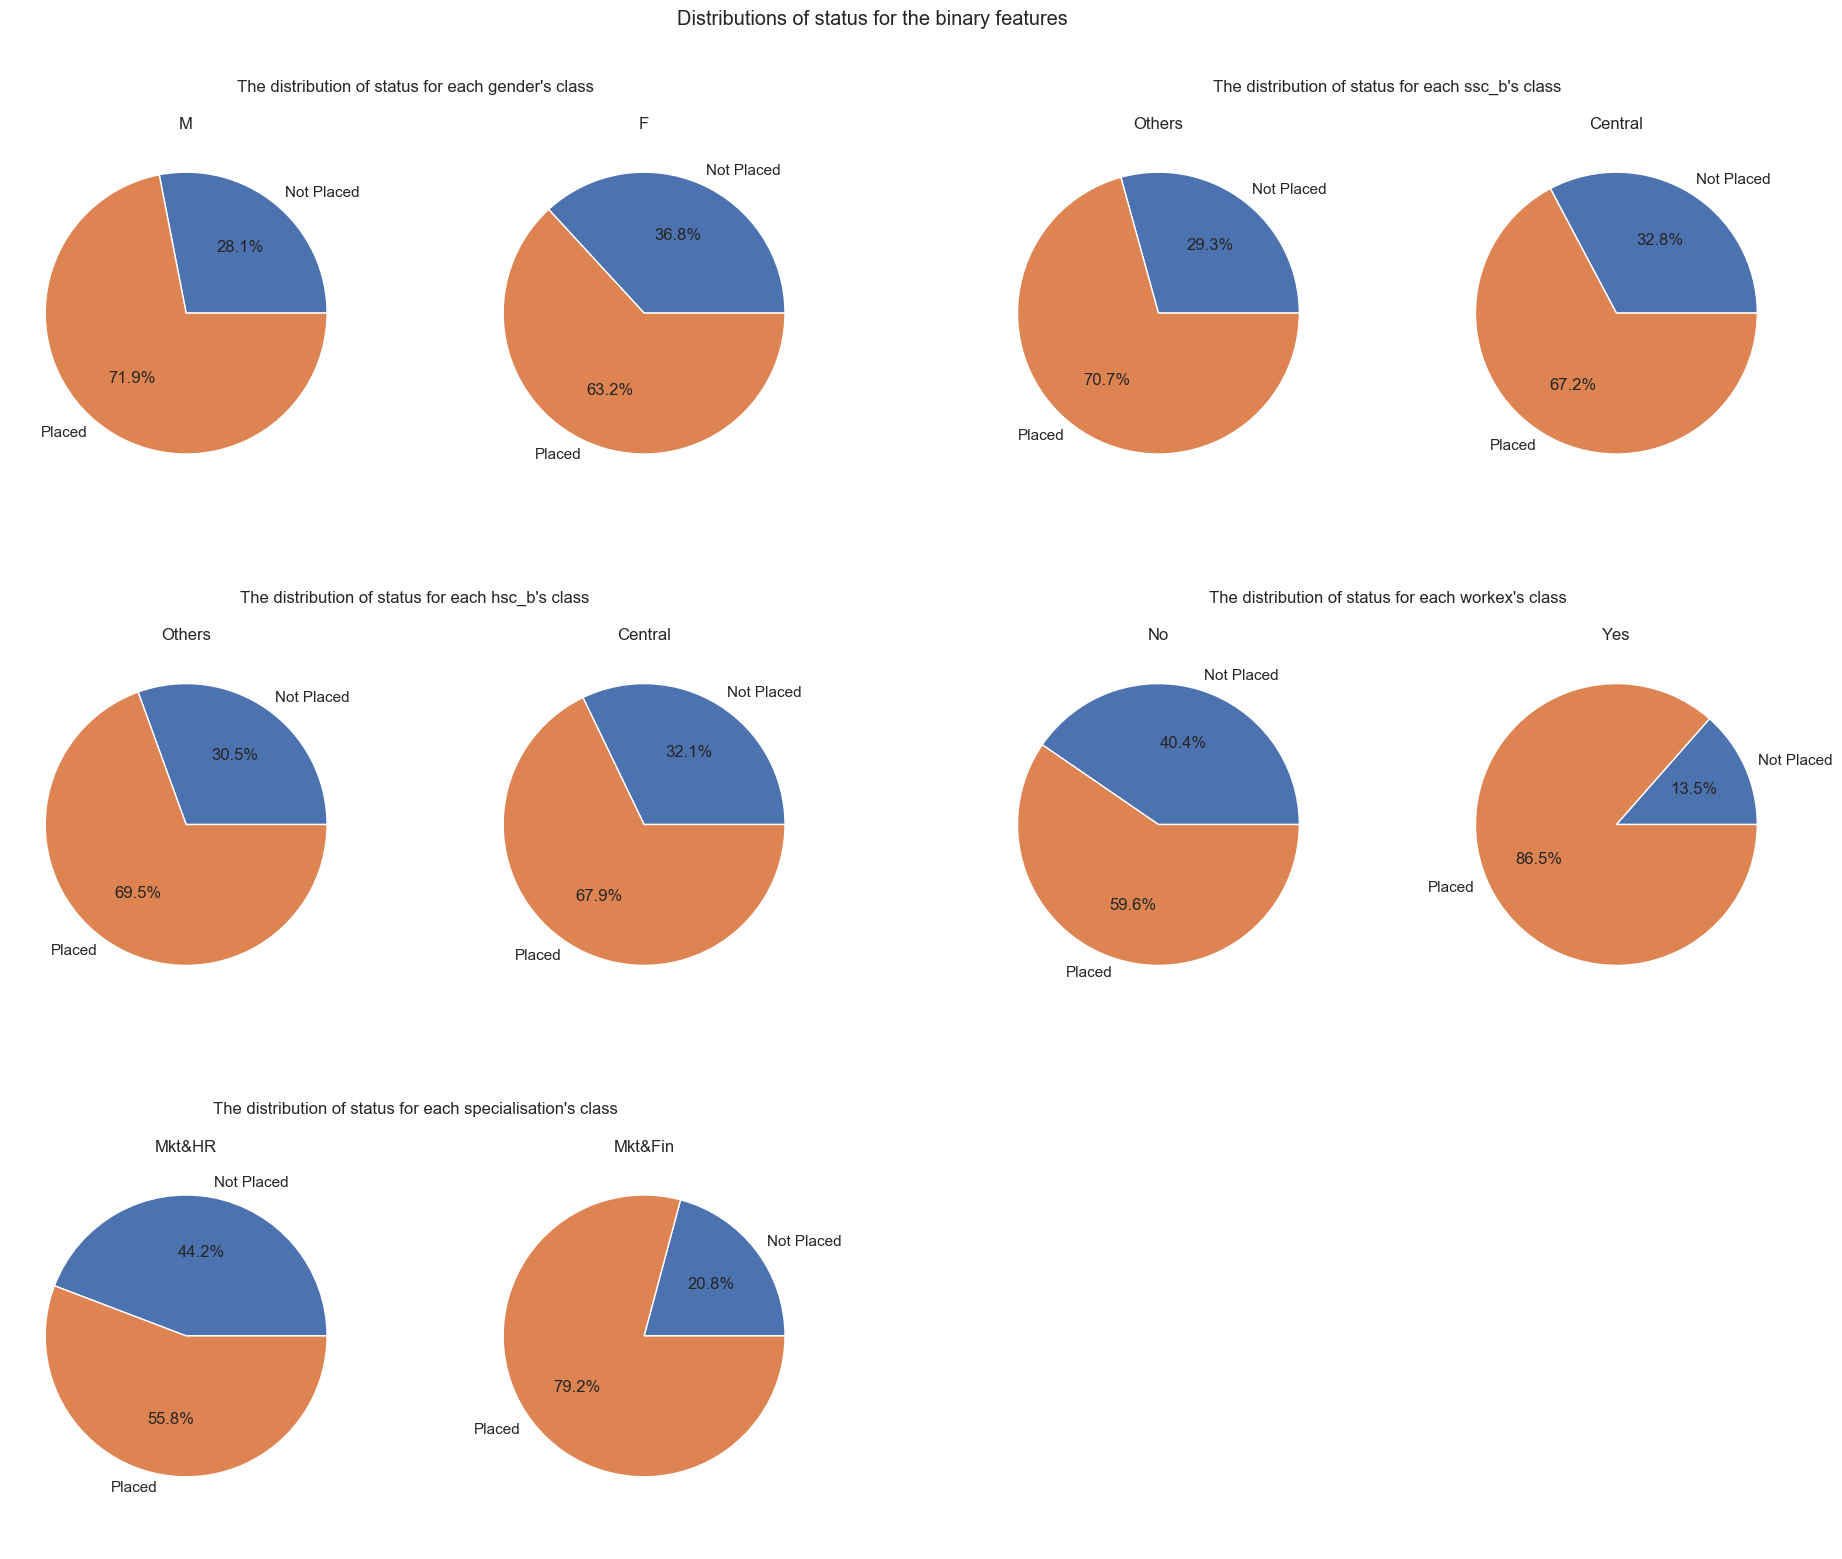

In [10]:
fig = plt.figure(figsize=(23, 18))
outer = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.2)

for feature_ind, feature_name in enumerate(bin_features):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[feature_ind], 
                                             wspace=0.3, hspace=0.3)
    
    ax = plt.Subplot(fig, outer[feature_ind])
    ax.set_title(f'The distribution of status for each {feature_name}\'s class')
    ax.axis('off')
    fig.add_subplot(ax)
    
    for pie_ind, f_class in enumerate(data[feature_name].unique()):
        ax = plt.Subplot(fig, inner[pie_ind])
        f_class_status_vc = data[data[feature_name] == f_class]['status'].value_counts().sort_index()
        ax.pie(f_class_status_vc.values, labels=f_class_status_vc.index, autopct='%1.1f%%')
        ax.set_title(f_class)
        fig.add_subplot(ax)

fig.suptitle('Distributions of status for the binary features')
fig.subplots_adjust(top=0.93)
fig.show()

__Question 3.__ (Which degree specialization is much demanded by corporate?) Look's like that Mkt&Fin is.

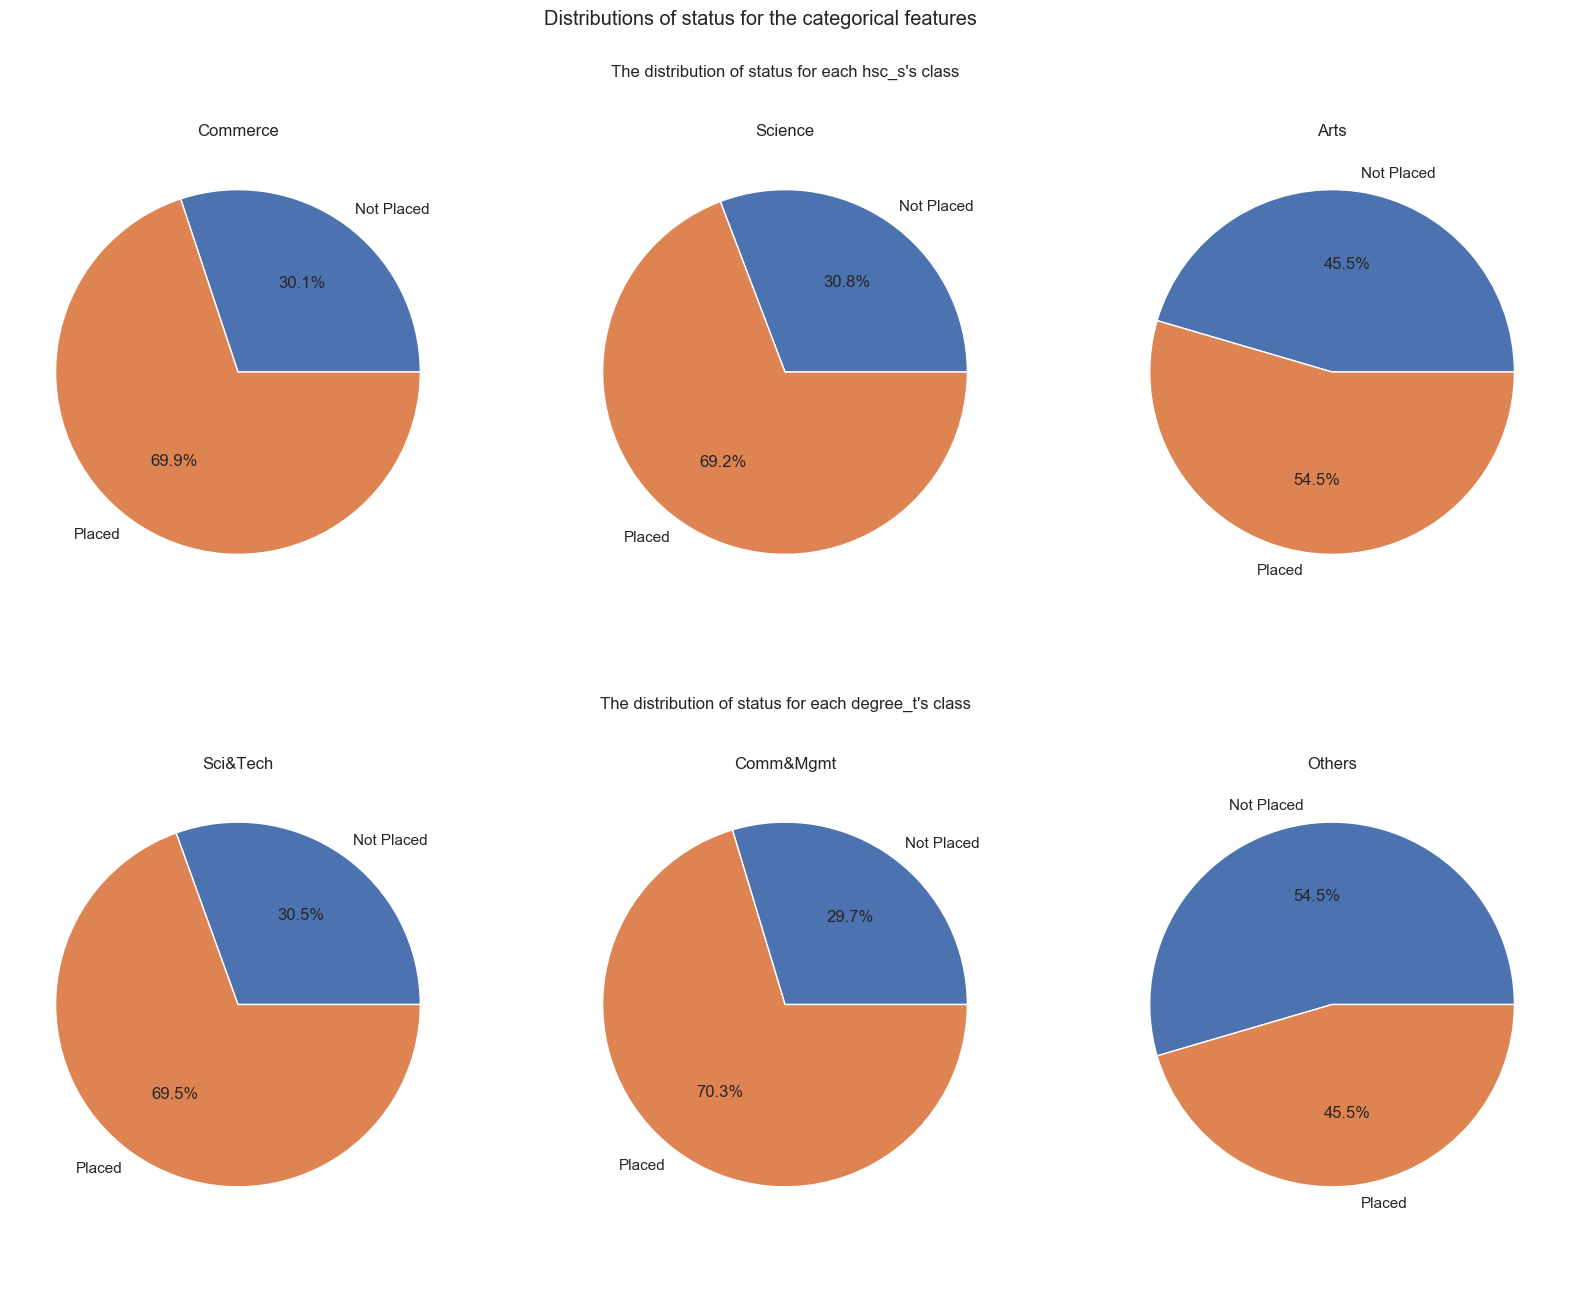

In [11]:
fig = plt.figure(figsize=(20, 15))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.1)

for feature_ind, feature_name in enumerate(cat_features):
    inner = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[feature_ind], 
                                             wspace=0.2, hspace=0.2)
    
    ax = plt.Subplot(fig, outer[feature_ind])
    ax.set_title(f'The distribution of status for each {feature_name}\'s class')
    ax.axis('off')
    fig.add_subplot(ax)
    
    for pie_ind, f_class in enumerate(data[feature_name].unique()):
        ax = plt.Subplot(fig, inner[pie_ind])
        f_class_status_vc = data[data[feature_name] == f_class]['status'].value_counts().sort_index()
        ax.pie(f_class_status_vc.values, labels=f_class_status_vc.index, autopct='%1.1f%%')
        ax.set_title(f_class)
        fig.add_subplot(ax)

fig.suptitle('Distributions of status for the categorical features')
fig.subplots_adjust(top=0.93)
fig.show()

In [12]:
# transforming status into binary feature to calculate proportions
data_01_status = data.copy()
data_01_status['status'].replace({'Placed': 1, 'Not Placed': 0}, inplace=True)

In [13]:
# proportions of placed people for different binary/categorical features values combinations
bin_x_cat_status_props = pd.pivot_table(data_01_status, index=cat_features, columns=bin_features, 
                                        values='status', aggfunc=np.mean)

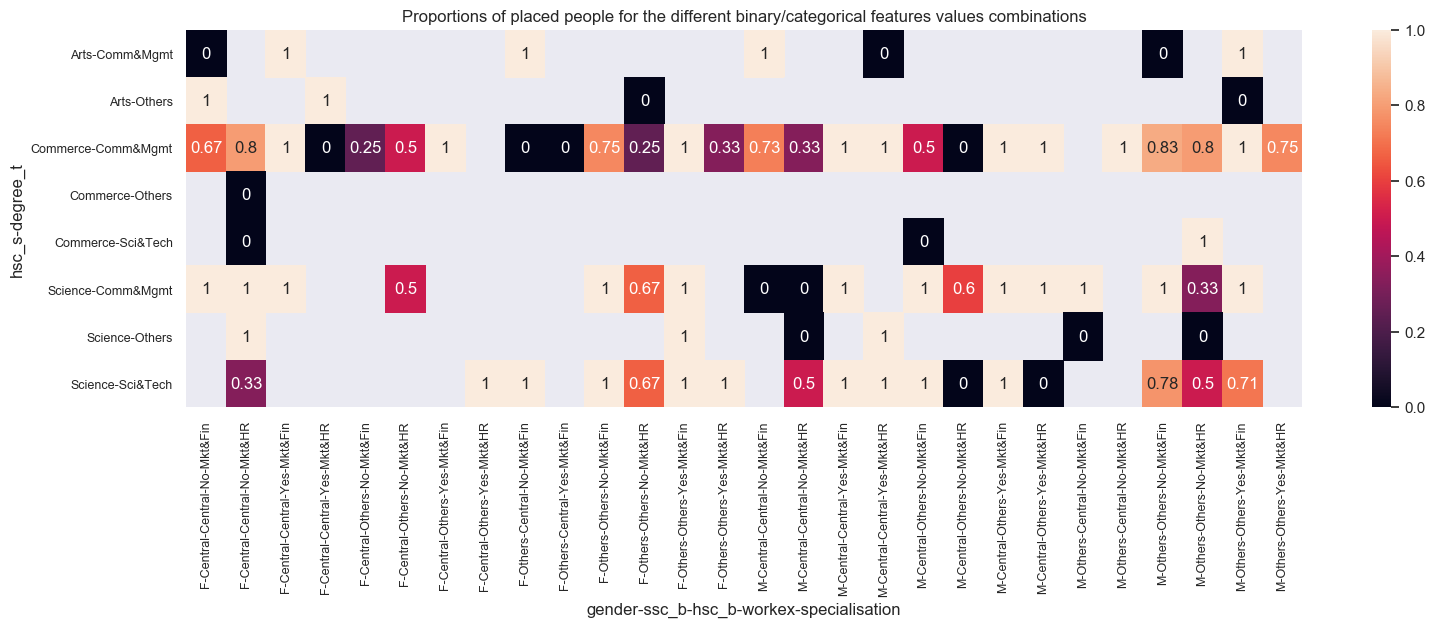

In [14]:
plt.figure(figsize=(18, 5))
sns.heatmap(bin_x_cat_status_props, annot=True).tick_params(labelsize=9)
plt.title('Proportions of placed people for the different binary/categorical features values combinations')
plt.show()

In [15]:
print('Top of the binary features combinations:')
display(pd.DataFrame((
    bin_x_cat_status_props.sum(axis=0) / (bin_x_cat_status_props.shape[0] - bin_x_cat_status_props.isna().sum(axis=0))
).sort_values(ascending=False), columns=['Mean proportion of placed people']))

print('\n\nTop of the categorical features combinations:')
display(pd.DataFrame((
    bin_x_cat_status_props.sum(axis=1) / (bin_x_cat_status_props.shape[1] - bin_x_cat_status_props.isna().sum(axis=1))
).sort_values(ascending=False), columns=['Mean proportion of placed people']))

Top of the binary features combinations:


Mean proportion of placed people
gender ssc_b   hsc_b   workex specialisation                                  
F      Central Central Yes    Mkt&Fin                                 1.000000
               Others  Yes    Mkt&Fin                                 1.000000
M      Others  Central No     Mkt&HR                                  1.000000
F      Central Others  Yes    Mkt&HR                                  1.000000
M      Central Others  Yes    Mkt&Fin                                 1.000000
F      Others  Others  Yes    Mkt&Fin                                 1.000000
M      Central Central Yes    Mkt&Fin                                 1.000000
F      Others  Others  No     Mkt&Fin                                 0.916667
M      Others  Others  Yes    Mkt&HR                                  0.750000
       Central Central Yes    Mkt&HR                                  0.750000
       Others  Others  Yes    Mkt&Fin                                 0.742857
F      Others  Central No     Mkt&Fin                                 0.666667
               Others  Yes    Mkt&HR                                  0.666667
M      Central Others  Yes    Mkt&HR                                  0.666667
F      Central Central No     Mkt&Fin                                 0.666667
M      Others  Others  No     Mkt&Fin                                 0.652778
       Central Others  No     Mkt&Fin                                 0.625000
               Central No     Mkt&Fin                                 0.577778
       Others  Others  No     Mkt&HR                                  0.526667
F      Central Central No     Mkt&HR                                  0.522222
M      Others  Central No     Mkt&Fin                                 0.500000
F      Central Others  No     Mkt&HR                                  0.500000
               Central Yes    Mkt&HR                                  0.500000
       Others  Others  No     Mkt&HR                                  0.395833
       Central Others  No     Mkt&Fin                                 0.250000
M      Central Central No     Mkt&HR                                  0.208333
               Others  No     Mkt&HR                                  0.200000
F      Others  Central Yes    Mkt&Fin                                 0.000000



Top of the categorical features combinations:


Mean proportion of placed people
hsc_s    degree_t                                   
Science  Comm&Mgmt                          0.783333
         Sci&Tech                           0.734827
Commerce Comm&Mgmt                          0.634615
Arts     Comm&Mgmt                          0.571429
Science  Others                             0.500000
Arts     Others                             0.500000
Commerce Sci&Tech                           0.333333
         Others                             0.000000

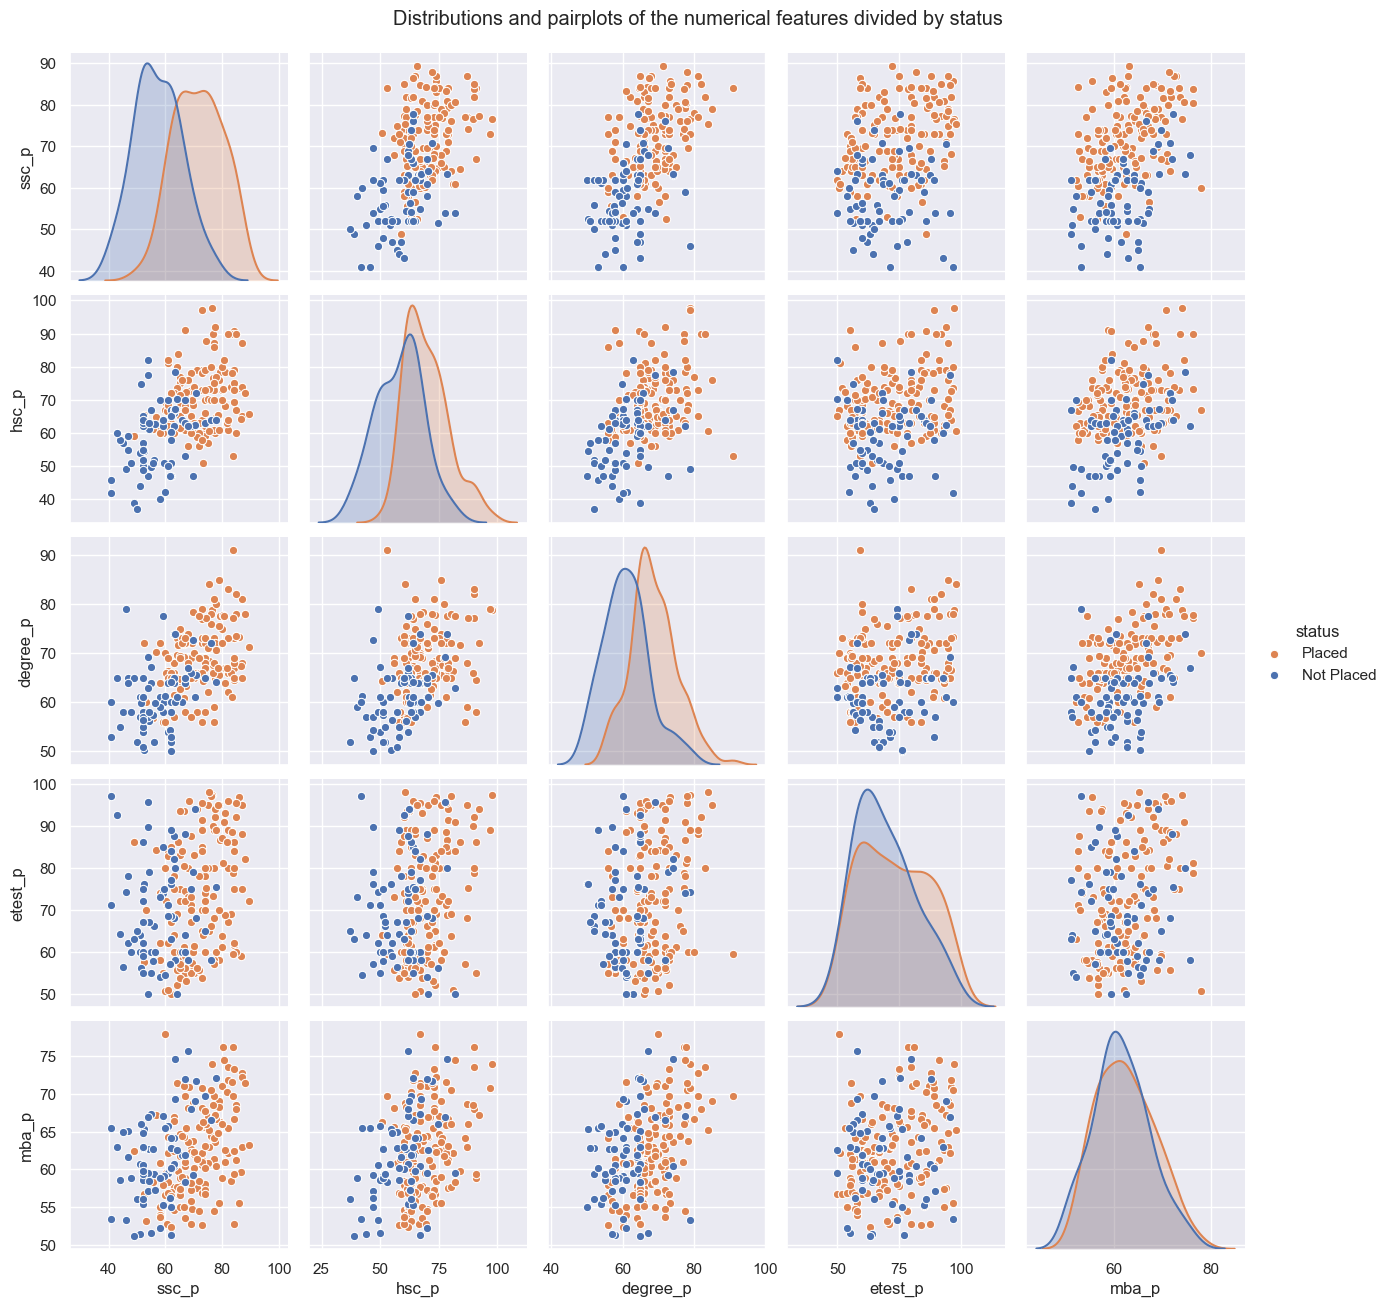

In [16]:
orange = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
pp = sns.pairplot(data[num_features + ['status']], hue='status', palette={'Placed': orange, 'Not Placed': blue})
pp.fig.suptitle('Distributions and pairplots of the numerical features divided by status', y=1.03)
pp.fig.show()

__Question 2.__ (Does percentage matters for one to get placed?) Look's like `ssc_p`, `hsc_p` and `degree_p` do if to divide them by `status` and all do if we use them in pairs with each other.

## Statistics

(__Question 4.__)

### Binary features

In [17]:
def matthews_correlation(contingency_table):
    '''Matthews correlation calculation.'''
    a, b = contingency_table[0]
    c, d = contingency_table[1]

    n = np.sum(contingency_table)
    acabn = (a + c) * (a + b) / n
    accdn = (a + c) * (c + d) / n
    bdabn = (b + d) * (a + b) / n
    bdcdn = (b + d) * (c + d) / n
    if n < 40 or np.any(np.array([acabn, accdn, bdabn, bdcdn]) < 5):
        raise ValueError('Contingency table isn\'t suitable for Matthews correlation calculation.')

    p_value = stats.chi2_contingency(contingency_table)[1]
    corr = (a * d - b * c) / np.sqrt((a + b) * (a + c) * (b + d) * (c + d))
    return corr, p_value


def proportion_confint(sample, alpha=0.05):
    '''Wilson\'s сonfidence interval for a proportion.'''
    p = np.mean(sample)
    n = len(sample)

    z = stats.norm.ppf(1 - alpha / 2)
    left_boundary = 1 / (1 + z ** 2 / n) * (p + z ** 2 / (2 * n) \
                                            - z * np.sqrt(p * (1 - p) / n + z ** 2 / (4 * n ** 2)))
    right_boundary = 1 / (1 + z ** 2 / n) * (p + z ** 2 / (2 * n) \
                                             + z * np.sqrt(p * (1 - p) / n + z ** 2 / (4 * n ** 2)))

    return left_boundary, right_boundary


def proportions_diff_confint_ind(sample1, sample2, alpha=0.05):
    '''Confidence interval for the difference in two independent proportions.'''
    z = stats.norm.ppf(1 - alpha / 2)
    p1 = np.mean(sample1)
    p2 = np.mean(sample2)
    n1 = len(sample1)
    n2 = len(sample2)

    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)

    return left_boundary, right_boundary


def proportions_ztest_ind(sample1, sample2, alternative='two-sided'):
    '''Z-test for two independent proportions.'''
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError('Alternative not recognized, should be \'two-sided\', \'less\' or \'greater\'.')

    p1 = np.mean(sample1)
    p2 = np.mean(sample2)
    n1 = len(sample1)
    n2 = len(sample2)

    P = (p1 * n1 + p2 * n2) / (n1 + n2)
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))

    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

    if alternative == 'less':
        p_value = stats.norm.cdf(z_stat)

    if alternative == 'greater':
        p_value = 1 - stats.norm.cdf(z_stat)

    return z_stat, p_value

In [18]:
print('BINARY FEATURES\n'
      '===============\n\n')
for feature_name in bin_features:
    class1, class2 = data_01_status[feature_name].unique()
    class1_status = data_01_status[data[feature_name] == class1].status
    class2_status = data_01_status[data[feature_name] == class2].status
    
    print(f'Feature: {feature_name}\n------')
    
    print('Contingency table:')
    contingency_table = pd.crosstab(data['status'], data[feature_name])
    display(contingency_table)
    corr, p = matthews_correlation(contingency_table.values)
    print(f'Correlation between status and {feature_name}: {round(corr, 4)}, p-value: {p}')
    if p < 0.05:
        print(f'There is a correlation between {feature_name} and status.')
    else:
        print(f'There isn\'t any correlation between {feature_name} and status.')
        
    print()
    
    print(f'The proportion of placed people for {class1}: {round(np.mean(class1_status), 4)}')
    print(f'The proportion of placed people for {class2}: {round(np.mean(class2_status), 4)}')
    
    class1_confint = list(map(lambda lim: round(lim, 4), proportion_confint(class1_status)))
    class2_confint = list(map(lambda lim: round(lim, 4), proportion_confint(class2_status)))
    print(f'The confidence interval (95%) for {class1}: {class1_confint}')
    print(f'The confidence interval (95%) for {class2}: {class2_confint}')
    if class2_confint[0] < class1_confint[0] < class2_confint[1] or \
       class2_confint[0] < class1_confint[1] < class2_confint[1]:
        print('The intervals overlap.')
    else:
        print('The intervals don\'t overlap.')
    
    print()
    
    if np.mean(class1_status) > np.mean(class2_status):
        bigger_prop, smaller_prop = class1_status, class2_status
    else:
        bigger_prop, smaller_prop = class2_status, class1_status
    
    print(f'The difference in the proportions: {round(np.mean(bigger_prop) - np.mean(smaller_prop), 4)}')
    prop_diff_confint = list(map(lambda lim: round(lim, 4), proportions_diff_confint_ind(bigger_prop, 
                                                                                         smaller_prop)))
    print(f'The confidence interval (95%) for the difference in the proportions: {prop_diff_confint}')
    if prop_diff_confint[0] > 0:
        print(f'The proportions may differ by at least {prop_diff_confint[0]}.')
    else:
        print('The difference between the proportions may be 0.')
    
    print()
    
    p = proportions_ztest_ind(class1_status, class2_status)[1]
    print(f'Z-test result (two-sided): {p} (p-value)')
    if p < 0.05:
        print('The proportions are probably unequal.')
    else:
        print('The proportions are probably equal.')
    
    print('\n\n')

BINARY FEATURES


Feature: gender
------
Contingency table:


gender,F,M
status,,
Not Placed,28,39
Placed,48,100


Correlation between status and gender: 0.0907, p-value: 0.23980260881037568
There isn't any correlation between gender and status.

The proportion of placed people for M: 0.7194
The proportion of placed people for F: 0.6316
The confidence interval (95%) for M: [0.6396, 0.7874]
The confidence interval (95%) for F: [0.5193, 0.7312]
The intervals overlap.

The difference in the proportions: 0.0878
The confidence interval (95%) for the difference in the proportions: [-0.0438, 0.2195]
The difference between the proportions may be 0.

Z-test result (two-sided): 0.1836866900162275 (p-value)
The proportions are probably equal.



Feature: ssc_b
------
Contingency table:


ssc_b,Central,Others
status,,
Not Placed,38,29
Placed,78,70


Correlation between status and ssc_b: 0.0373, p-value: 0.6897729431530739
There isn't any correlation between ssc_b and status.

The proportion of placed people for Others: 0.7071
The proportion of placed people for Central: 0.6724
The confidence interval (95%) for Others: [0.611, 0.7876]
The confidence interval (95%) for Central: [0.5827, 0.7511]
The intervals overlap.

The difference in the proportions: 0.0347
The confidence interval (95%) for the difference in the proportions: [-0.0892, 0.1585]
The difference between the proportions may be 0.

Z-test result (two-sided): 0.5844651480115948 (p-value)
The proportions are probably equal.



Feature: hsc_b
------
Contingency table:


hsc_b,Central,Others
status,,
Not Placed,27,40
Placed,57,91


Correlation between status and hsc_b: 0.0169, p-value: 0.9222837052885
There isn't any correlation between hsc_b and status.

The proportion of placed people for Others: 0.6947
The proportion of placed people for Central: 0.6786
The confidence interval (95%) for Others: [0.6112, 0.767]
The confidence interval (95%) for Central: [0.5728, 0.7687]
The intervals overlap.

The difference in the proportions: 0.0161
The confidence interval (95%) for the difference in the proportions: [-0.1112, 0.1433]
The difference between the proportions may be 0.

Z-test result (two-sided): 0.8037818499464533 (p-value)
The proportions are probably equal.



Feature: workex
------
Contingency table:


workex,No,Yes
status,,
Not Placed,57,10
Placed,84,64


Correlation between status and workex: 0.2761, p-value: 9.906584720516494e-05
There is a correlation between workex and status.

The proportion of placed people for No: 0.5957
The proportion of placed people for Yes: 0.8649
The confidence interval (95%) for No: [0.5132, 0.6732]
The confidence interval (95%) for Yes: [0.7688, 0.9249]
The intervals don't overlap.

The difference in the proportions: 0.2691
The confidence interval (95%) for the difference in the proportions: [0.1567, 0.3815]
The proportions may differ by at least 0.1567.

Z-test result (two-sided): 5.169385992243036e-05 (p-value)
The proportions are probably unequal.



Feature: specialisation
------
Contingency table:


specialisation,Mkt&Fin,Mkt&HR
status,,
Not Placed,25,42
Placed,95,53


Correlation between status and specialisation: -0.2507, p-value: 0.00042018425858864284
There is a correlation between specialisation and status.

The proportion of placed people for Mkt&HR: 0.5579
The proportion of placed people for Mkt&Fin: 0.7917
The confidence interval (95%) for Mkt&HR: [0.4577, 0.6536]
The confidence interval (95%) for Mkt&Fin: [0.7105, 0.8547]
The intervals don't overlap.

The difference in the proportions: 0.2338
The confidence interval (95%) for the difference in the proportions: [0.1103, 0.3573]
The proportions may differ by at least 0.1103.

Z-test result (two-sided): 0.00023754674658182928 (p-value)
The proportions are probably unequal.





The differences in proportions of placed people for `workex` and `specialization` (__Question 3.__ Which degree specialization is much demanded by corporate?) classes are statistically significant, differences in all the rest ones - aren't. People with work experience are placed at least 15% more often, people of Mkt&Fin specialization - al least 11% more often.

### Categorical features

In [19]:
def cramers_v(contingency_table):
    '''Cramer\'s V coefficient.'''
    n = np.sum(contingency_table)
    ct_nrows, ct_ncols = contingency_table.shape
    if n < 40 or np.sum(contingency_table < 5) / (ct_nrows * ct_ncols) > 0.2:
        raise ValueError('Contingency table isn\'t suitable for Cramers\'s V coefficient calculation.')

    chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
    corr = np.sqrt(chi2 / (n * (min(ct_nrows, ct_ncols) - 1)))
    return corr, p_value

In [20]:
print('CATEGORICAL FEATURES\n'
      '====================\n\n')
for feature_name in cat_features:
    print(f'Feature: {feature_name}\n------')
    print('Contingency table:')
    contingency_table = pd.crosstab(data['status'], data[feature_name])
    display(contingency_table)
    corr, p = cramers_v(contingency_table.values)
    print(f'Correlation between status and {feature_name}: {round(corr, 4)}, p-value: {p}')
    if p < 0.05:
        print(f'There is a correlation between {feature_name} and status.')
    else:
        print(f'There isn\'t any correlation between {feature_name} and status.')
    
    print('\n\n')

CATEGORICAL FEATURES


Feature: hsc_s
------
Contingency table:


hsc_s,Arts,Commerce,Science
status,,,
Not Placed,5,34,28
Placed,6,79,63


Correlation between status and hsc_s: 0.072, p-value: 0.5727118511343621
There isn't any correlation between hsc_s and status.



Feature: degree_t
------
Contingency table:


degree_t,Comm&Mgmt,Others,Sci&Tech
status,,,
Not Placed,43,6,18
Placed,102,5,41


Correlation between status and degree_t: 0.1175, p-value: 0.22661076190356658
There isn't any correlation between degree_t and status.





None of the categorical features has a significant correlation with `status`.

### Numerical features

Not all numerical features are normally distributed:

In [21]:
norm_features = [feature_name for feature_name in num_features if stats.shapiro(data[feature_name])[1] < 0.05]
print(f'Numerical features: {", ".join(num_features)}')
print(f'Features that are probably normally distributed: {", ".join(norm_features)}')

Numerical features: ssc_p, hsc_p, degree_p, etest_p, mba_p
Features that are probably normally distributed: ssc_p, hsc_p, etest_p, mba_p


And only two of them are normally distributed if we divide them by `status`:

In [22]:
for feature_name in num_features:
    feature_placed = data[data.status == 'Placed'][feature_name]
    feature_not_placed = data[data.status == 'Not Placed'][feature_name]
    
    p_placed = stats.shapiro(feature_placed)[1]
    p_not_placed = stats.shapiro(feature_not_placed)[1]
    if p_placed < 0.05 and p_not_placed < 0.05:
        print(f'The both distributions of {feature_name} for the different status are probably normally distributed.')

The both distributions of degree_p for the different status are probably normally distributed.
The both distributions of etest_p for the different status are probably normally distributed.


So to compare them we will use Student's t-test for the normally distributed pairs and permutation test for the rest.

In [23]:
norm_num_features = ['degree_p', 'etest_p']

In [24]:
def tconfint(sample, alpha=0.05):
    '''Confidence interval based on Student t distribution.'''
    mean = np.mean(sample)
    S = np.std(sample, ddof=1)
    n = len(sample)

    t = stats.t.ppf(1 - alpha / 2, n - 1)
    left_boundary = mean - t * S / np.sqrt(n)
    right_boundary = mean + t * S / np.sqrt(n)

    return left_boundary, right_boundary


def tconfint_diff(sample1, sample2, alpha=0.05):
    '''Confidence interval based on Student t distribution for
    the difference in means of two samples.'''
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    s1 = np.std(sample1, ddof=1)
    s2 = np.std(sample2, ddof=1)
    n1 = len(sample1)
    n2 = len(sample2)
    
    sem1 = np.var(sample1) / (n1 - 1)
    sem2 = np.var(sample2) / (n2 - 1)
    semsum = sem1 + sem2
    z1 = (sem1 / semsum) ** 2 / (n1 - 1)
    z2 = (sem2 / semsum) ** 2 / (n2 - 1)
    dof = 1 / (z1 + z2)
    
    t = np.abs(stats.t.ppf(alpha / 2, dof))
    left_boundary = (mean1 - mean2) - t * np.sqrt((s1 ** 2) / n1 + (s2 ** 2) / n2)
    right_boundary = (mean1 - mean2) + t * np.sqrt((s1 ** 2) / n1 + (s2 ** 2) / n2)
    
    return left_boundary, right_boundary


def permutation_test_ind(sample1, sample2, max_permutations=None, alternative='two-sided'):
    '''Permutation test for two independent samples.'''
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError('Alternative not recognized, should be \'two-sided\', \'less\' or \'greater\'.')

    t_stat = np.mean(sample1) - np.mean(sample2)

    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)

    if max_permutations:
        index = list(range(n))
        indices = set([tuple(index)])
        for _ in range(max_permutations - 1):
            np.random.shuffle(index)
            indices.add(tuple(index))

        indices = [(index[:n1], index[n1:]) for index in indices]
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n))))
                    for index in itertools.combinations(range(n), n1)]

    zero_distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean()
                  for i in indices]

    if alternative == 'two-sided':
        p_value = sum([abs(x) >= abs(t_stat) for x in zero_distr]) / len(zero_distr)

    if alternative == 'less':
        p_value = sum([x <= t_stat for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        p_value = sum([x >= t_stat for x in zero_distr]) / len(zero_distr)

    return t_stat, p_value

In [25]:
print('NUMERICAL FEATURES\n'
      '==================\n\n')
for feature_name in num_features:
    feature_placed = data[data.status == 'Placed'][feature_name]
    feature_not_placed = data[data.status == 'Not Placed'][feature_name]
    
    print(f'Feature: {feature_name}\n------')
    
    corr, p = stats.pointbiserialr(data_01_status.status, data[feature_name])
    print(f'Correlation between status and {feature_name}: {round(corr, 4)}, p-value: {p}')
    if p < 0.05:
        print(f'There is a correlation between {feature_name} and status.')
    else:
        print(f'There isn\'t any correlation between {feature_name} and status.')
        
    print()
    
    print(f'Mean of {feature_name} for placed people:     {round(np.mean(feature_placed), 4)}')
    print(f'Mean of {feature_name} for not placed people: {round(np.mean(feature_not_placed), 4)}')
    
    feature_placed_confint = list(map(lambda lim: round(lim, 4), tconfint(feature_placed)))
    feature_not_placed_confint = list(map(lambda lim: round(lim, 4), tconfint(feature_not_placed)))
    
    print(f'Confidence interval (95%) of mean {feature_name} for placed people:     {feature_placed_confint}')
    print(f'Confidence interval (95%) of mean {feature_name} for not placed people: {feature_not_placed_confint}')
    if feature_not_placed_confint[0] < feature_placed_confint[0] < feature_not_placed_confint[1] or \
       feature_not_placed_confint[0] < feature_placed_confint[1] < feature_not_placed_confint[1]:
        print('The intervals overlap.')
    else:
        print('The intervals don\'t overlap.')
    
    print()
    
    if np.mean(feature_placed) > np.mean(feature_not_placed):
        bigger_mean, smaller_mean = feature_placed, feature_not_placed
    else:
        bigger_mean, smaller_mean = feature_not_placed, feature_placed
    
    mean_diff_confint = list(map(lambda lim: round(lim, 4), tconfint_diff(bigger_mean, smaller_mean)))
    print(f'Difference in means: {round(np.mean(bigger_mean) - np.mean(smaller_mean), 4)}')
    print(f'Confidence interval (95%) for the difference in means: {mean_diff_confint}')
    if mean_diff_confint[0] > 0:
        print(f'The means may differ by at least {mean_diff_confint[0]}.')
    else:
        print('The difference in means between the samples may be 0.')
        
    print()

    if feature_name in norm_num_features:
        comparison_subject = 'means'
        p = stats.ttest_ind(feature_placed, feature_not_placed, equal_var=False)[1]
        print(f'Student\'s t-test result (two-sided): {p} (p-value)')
    else:
        comparison_subject = 'distributions'
        p = permutation_test_ind(feature_placed, feature_not_placed, max_permutations=5000)[1]
        print(f'Permutation test result (two-sided): {p} (p-value)')
    
    if p < 0.05:
        print(f'The {comparison_subject} of the samples are probably unequal.')
    else:
        print(f'The {comparison_subject} of the samples are probably equal.')
    
    print('\n\n')

NUMERICAL FEATURES


Feature: ssc_p
------
Correlation between status and ssc_p: 0.6079, p-value: 4.11520104388515e-23
There is a correlation between ssc_p and status.

Mean of ssc_p for placed people:     71.7215
Mean of ssc_p for not placed people: 57.544
Confidence interval (95%) of mean ssc_p for placed people:     [70.3057, 73.1373]
Confidence interval (95%) of mean ssc_p for not placed people: [55.4965, 59.5915]
The intervals don't overlap.

Difference in means: 14.1775
Confidence interval (95%) for the difference in means: [11.7029, 16.652]
The means may differ by at least 11.7029.

Permutation test result (two-sided): 0.0002 (p-value)
The distributions of the samples are probably unequal.



Feature: hsc_p
------
Correlation between status and hsc_p: 0.4912, p-value: 1.8492127569316574e-14
There is a correlation between hsc_p and status.

Mean of hsc_p for placed people:     69.9266
Mean of hsc_p for not placed people: 58.3955
Confidence interval (95%) of mean hsc_p for placed 

__Question 2.__ (Does percentage matters for one to get placed?) The differences in distributions of `ssc_p` and `hsc_p`, and in means of `degree_p` and `etest_p` (doubtful) for placed and not placed people are statistically significant, difference in distributions of `mba_p` - isn't.

## Logistic regression model

Let's train a Logisctic regression model and look at it's weights. But firstly transform percents to proportions (instead of scaling):

In [26]:
data_01_status[num_features] = data[num_features] / 100
data_01_status[num_features].describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p
count,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.673034,0.663332,0.663702,0.721006,0.622782
std,0.108272,0.108975,0.073587,0.132760,0.058334
min,0.408900,0.370000,0.500000,0.500000,0.512100
25%,0.606000,0.609000,0.610000,0.600000,0.579450
50%,0.670000,0.650000,0.660000,0.710000,0.620000
75%,0.757000,0.730000,0.720000,0.835000,0.662550
max,0.894000,0.977000,0.910000,0.980000,0.778900


In [27]:
data_01_status.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,M,0.6700,Others,0.9100,Others,Commerce,0.5800,Sci&Tech,No,0.550,Mkt&HR,0.5880,1
1,M,0.7933,Central,0.7833,Others,Science,0.7748,Sci&Tech,Yes,0.865,Mkt&Fin,0.6628,1
2,M,0.6500,Central,0.6800,Central,Arts,0.6400,Comm&Mgmt,No,0.750,Mkt&Fin,0.5780,1
3,M,0.5600,Central,0.5200,Central,Science,0.5200,Sci&Tech,No,0.660,Mkt&HR,0.5943,0
4,M,0.8580,Central,0.7360,Central,Commerce,0.7330,Comm&Mgmt,No,0.968,Mkt&Fin,0.5550,1


Fitting a model and printing statistics:

In [28]:
formula = 'status ~ C(' + ') + C('.join(bin_features + cat_features) + ') + ' + ' + '.join(num_features)
formula

'status ~ C(gender) + C(ssc_b) + C(hsc_b) + C(workex) + C(specialisation) + C(hsc_s) + C(degree_t) + ssc_p + hsc_p + degree_p + etest_p + mba_p'

In [29]:
model = smf.logit(formula, data=data_01_status)
fitted = model.fit()
print(fitted.summary())

Optimization terminated successfully.
         Current function value: 0.231806
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                  215
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                           14
Date:                Sun, 24 May 2020   Pseudo R-squ.:                  0.6264
Time:                        19:28:06   Log-Likelihood:                -49.838
converged:                       True   LL-Null:                       -133.39
Covariance Type:            nonrobust   LLR p-value:                 2.643e-28
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -18.3717      5.324     -3.451      0.001   

__p-value__ < 0.05 for `degree_t`, `workex`, `ssc_p`, `hsc_p`, `degree_p` and `mba_p` weights. Look's like other features aren't too important for the `status` prediction (if a logistic regression is used). Let's fit another model using only them:

In [30]:
formula = 'status ~ C(degree_t) + C(workex) + ssc_p + hsc_p + degree_p + mba_p'
model = smf.logit(formula, data=data_01_status)
fitted = model.fit()
print(fitted.summary())

Optimization terminated successfully.
         Current function value: 0.251513
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                  215
Model:                          Logit   Df Residuals:                      207
Method:                           MLE   Df Model:                            7
Date:                Sun, 24 May 2020   Pseudo R-squ.:                  0.5946
Time:                        19:28:06   Log-Likelihood:                -54.075
converged:                       True   LL-Null:                       -133.39
Covariance Type:            nonrobust   LLR p-value:                 6.259e-31
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -15.7115      3.968     -3.960      0.000     -23.489   

Seems it hasn't become much worse. 

Depending on model's info we can conclude:

- __Question 1.__ (Which factor influenced a candidate in getting placed?) `degree_t` (doubtful) and `workex` are.<br>
- __Question 2.__ (Does percentage matters for one to get placed?) Yes, `ssc_p`, `hsc_p`, `degree_p` and `mba_p` do.